# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [1]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=70e3930e-ea77-4b5b-9dc0-4275501dbf6a
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 115MB/s]


#### Import packages

In [2]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [3]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 64,
    n_epoch = 20,
    lr = 2e-3,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [4]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

cuda


#### Dataset and Dataloader

In [5]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [6]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ToTensor(),

])
eval_tfm = T.Compose([
    T.ToTensor(),
])

In [7]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)
image, label = next(iter(train_loader))
print(image.shape, label.shape)
print(image.min(), image.max())

torch.Size([128, 1, 64, 64]) torch.Size([128])
tensor(0.) tensor(1.)


#### Model

In [8]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          # nn.ReLU(),
          # nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
          nn.Linear(32 * 16 * 16, 1024),
          nn.ReLU(),
          nn.Linear(1024, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

#### training loop

In [9]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Linear-7                 [-1, 1024]       8,389,632
              ReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 7]           7,175
Total params: 8,401,607
Trainable params: 8,401,607
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.70
Params size (MB): 32.05
Estimated Total Size (MB): 33.77
-------------------------------------

100%|██████████| 181/181 [00:15<00:00, 11.72it/s]


Epoch: 1/20, train loss: 1.7770, train acc: 0.2850
Epoch: 1/20, valid loss: 1.6754, valid acc: 0.3349
== best valid acc: 0.3349 ==


100%|██████████| 181/181 [00:15<00:00, 12.02it/s]


Epoch: 2/20, train loss: 1.6419, train acc: 0.3543
Epoch: 2/20, valid loss: 1.6110, valid acc: 0.3751
== best valid acc: 0.3751 ==


100%|██████████| 181/181 [00:14<00:00, 12.63it/s]


Epoch: 3/20, train loss: 1.5956, train acc: 0.3771
Epoch: 3/20, valid loss: 1.5875, valid acc: 0.3751


100%|██████████| 181/181 [00:14<00:00, 12.43it/s]


Epoch: 4/20, train loss: 1.5472, train acc: 0.3996
Epoch: 4/20, valid loss: 1.5268, valid acc: 0.4043
== best valid acc: 0.4043 ==


100%|██████████| 181/181 [00:14<00:00, 12.70it/s]


Epoch: 5/20, train loss: 1.5138, train acc: 0.4104
Epoch: 5/20, valid loss: 1.4934, valid acc: 0.4216
== best valid acc: 0.4216 ==


100%|██████████| 181/181 [00:14<00:00, 12.62it/s]


Epoch: 6/20, train loss: 1.4763, train acc: 0.4278
Epoch: 6/20, valid loss: 1.4438, valid acc: 0.4362
== best valid acc: 0.4362 ==


100%|██████████| 181/181 [00:14<00:00, 12.75it/s]


Epoch: 7/20, train loss: 1.4358, train acc: 0.4484
Epoch: 7/20, valid loss: 1.4342, valid acc: 0.4435
== best valid acc: 0.4435 ==


100%|██████████| 181/181 [00:14<00:00, 12.75it/s]


Epoch: 8/20, train loss: 1.3984, train acc: 0.4613
Epoch: 8/20, valid loss: 1.4076, valid acc: 0.4530
== best valid acc: 0.4530 ==


100%|██████████| 181/181 [00:14<00:00, 12.62it/s]


Epoch: 9/20, train loss: 1.3723, train acc: 0.4719
Epoch: 9/20, valid loss: 1.3845, valid acc: 0.4612
== best valid acc: 0.4612 ==


100%|██████████| 181/181 [00:14<00:00, 12.67it/s]


Epoch: 10/20, train loss: 1.3448, train acc: 0.4818
Epoch: 10/20, valid loss: 1.3515, valid acc: 0.4680
== best valid acc: 0.4680 ==


100%|██████████| 181/181 [00:14<00:00, 12.48it/s]


Epoch: 11/20, train loss: 1.3225, train acc: 0.4915
Epoch: 11/20, valid loss: 1.3568, valid acc: 0.4758
== best valid acc: 0.4758 ==


100%|██████████| 181/181 [00:14<00:00, 12.52it/s]


Epoch: 12/20, train loss: 1.3061, train acc: 0.4988
Epoch: 12/20, valid loss: 1.3276, valid acc: 0.4941
== best valid acc: 0.4941 ==


100%|██████████| 181/181 [00:14<00:00, 12.45it/s]


Epoch: 13/20, train loss: 1.2940, train acc: 0.5069
Epoch: 13/20, valid loss: 1.3383, valid acc: 0.4728


100%|██████████| 181/181 [00:14<00:00, 12.79it/s]


Epoch: 14/20, train loss: 1.2718, train acc: 0.5154
Epoch: 14/20, valid loss: 1.3161, valid acc: 0.4948
== best valid acc: 0.4948 ==


100%|██████████| 181/181 [00:14<00:00, 12.68it/s]


Epoch: 15/20, train loss: 1.2531, train acc: 0.5204
Epoch: 15/20, valid loss: 1.3444, valid acc: 0.4798


100%|██████████| 181/181 [00:14<00:00, 12.74it/s]


Epoch: 16/20, train loss: 1.2473, train acc: 0.5256
Epoch: 16/20, valid loss: 1.2962, valid acc: 0.5023
== best valid acc: 0.5023 ==


100%|██████████| 181/181 [00:14<00:00, 12.72it/s]


Epoch: 17/20, train loss: 1.2285, train acc: 0.5315
Epoch: 17/20, valid loss: 1.3171, valid acc: 0.4865


100%|██████████| 181/181 [00:14<00:00, 12.59it/s]


Epoch: 18/20, train loss: 1.2177, train acc: 0.5362
Epoch: 18/20, valid loss: 1.2927, valid acc: 0.4992


100%|██████████| 181/181 [00:14<00:00, 12.72it/s]


Epoch: 19/20, train loss: 1.1987, train acc: 0.5480
Epoch: 19/20, valid loss: 1.2752, valid acc: 0.5071
== best valid acc: 0.5071 ==


100%|██████████| 181/181 [00:14<00:00, 12.40it/s]


Epoch: 20/20, train loss: 1.1874, train acc: 0.5515
Epoch: 20/20, valid loss: 1.2892, valid acc: 0.5083
== best valid acc: 0.5083 ==


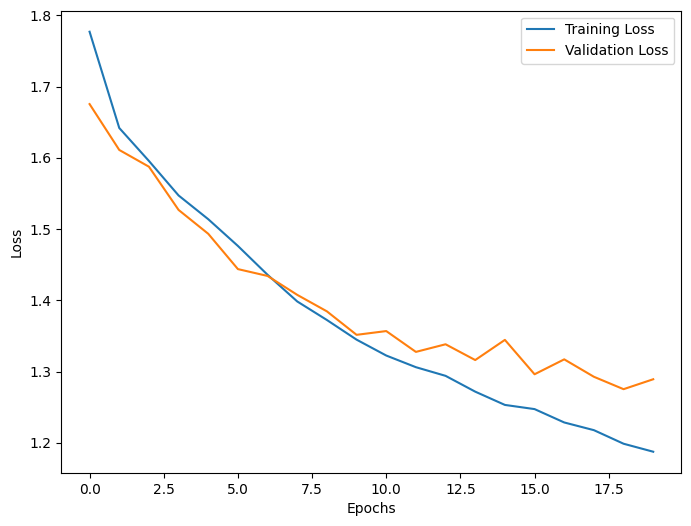

In [10]:
model = FaceExpressionNet().to(device)
summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

100%|██████████| 46/46 [00:02<00:00, 16.56it/s]


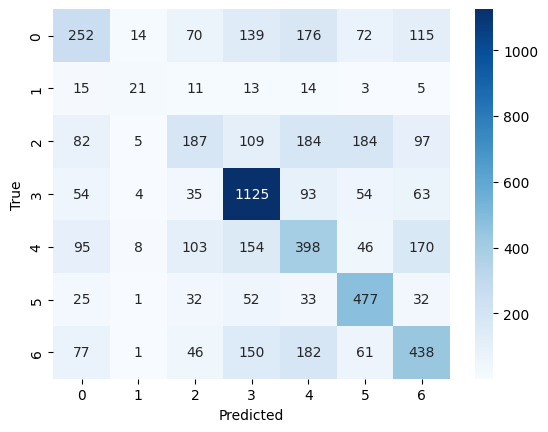

In [11]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

draw_confusion_matrix(model, valid_loader)


### Testing

In [12]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [13]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 55/55 [00:02<00:00, 26.46it/s]
